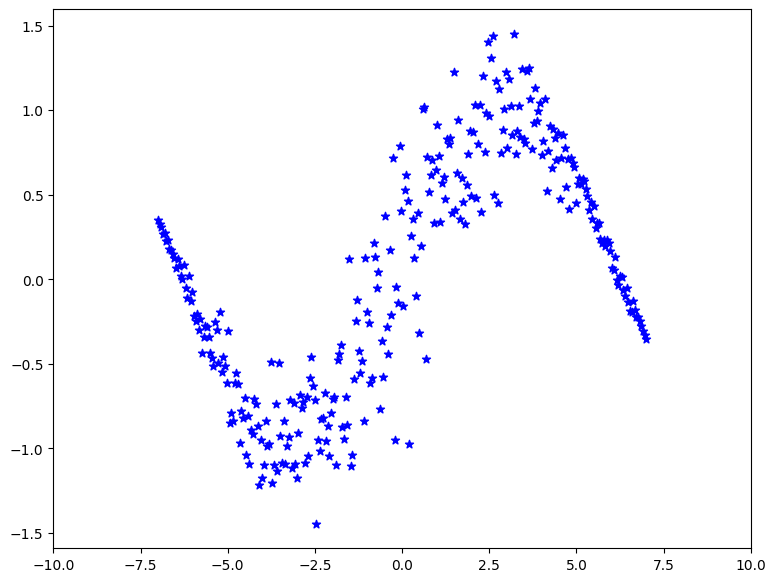

In [1]:
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.pyplot import scatter, figure
import math
import numpy as np
figure(figsize=(9, 7))

# Same range for all plots
plt.xlim([-10, 10])
start = -7
end = 7
n = 300

def sample_dataset(start, end, n):
    x = np.linspace(start, end, n)
    sample_mean = [math.sin(i/2) for i in x]

    sample_var = [abs((abs(start)+abs(end))/2 - abs(i))/16 for i in x]
    y = stats.norm(sample_mean, sample_var).rvs()
    return x, y

x_train, y_train = sample_dataset(start, end, n)
scatter(x_train, y_train, c="blue", marker="*")

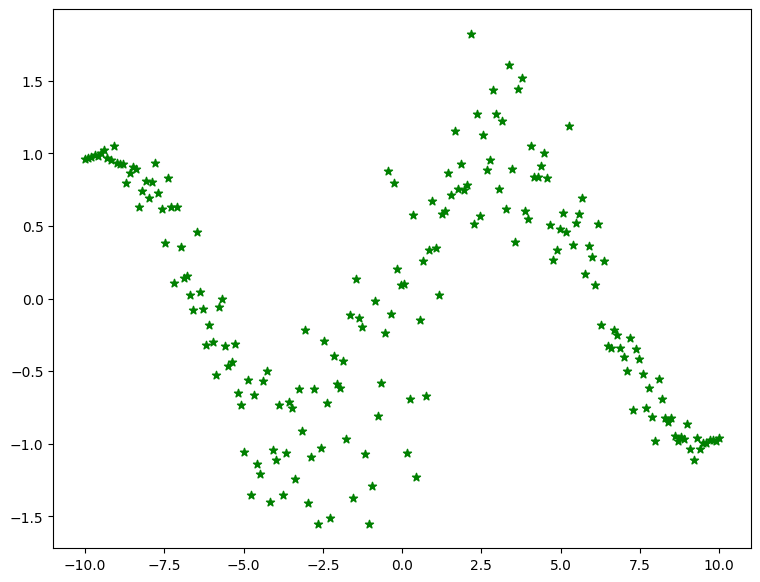

In [2]:
figure(figsize=(9, 7))
# Not exactely the same distribution, but works for now
x_test, y_test = sample_dataset(-10, 10, 200)
scatter(x_test, y_test, c="green", marker="*")

In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader

batch_size = 16

# Train
tensor_x = torch.Tensor(x_train).unsqueeze(1)
tensor_y = torch.Tensor(y_train).unsqueeze(1)
train_dataset = TensorDataset(tensor_x, tensor_y)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Test
tensor_x_test = torch.Tensor(x_test).unsqueeze(1)
tensor_y_test = torch.Tensor(y_test).unsqueeze(1)
test_dataset = TensorDataset(tensor_x_test, tensor_y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [18]:
from numpy.ma.core import outer
from sys import stderr
import torch.nn as nn
import torch.nn.functional as F

class DeepONet(nn.Module):
    def __init__(self):
        super(DeepONet, self).__init__()
        hidden_size = 64
        # We only have 1 input feature
        self.fc1 = nn.Linear(1, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.mu = nn.Linear(hidden_size, 1)
        self.var = nn.Linear(hidden_size, 1)
        self.fc3=nn.Linear(1,hidden_size)
        self.fc4=nn.Linear(hidden_size,hidden_size)

    def forward(self, x):
        self.noise = torch.randn(x.shape[0], x.shape[1])
        branch= torch.tanh(self.fc1(x))
        branch= torch.tanh(self.fc2(branch))
        trunk= torch.tanh(self.fc3(self.noise))
        trunk= torch.tanh(self.fc4(trunk))
        prod_branch_trunk=torch.multiply(branch,trunk)
        mu = self.mu(prod_branch_trunk)
        var = torch.exp(self.var(prod_branch_trunk))

        return mu, var

net = DeepONet()
print(net)
print("Params:", sum(p.numel() for p in net.parameters() if p.requires_grad))


DeepONet(
  (fc1): Linear(in_features=1, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (mu): Linear(in_features=64, out_features=1, bias=True)
  (var): Linear(in_features=64, out_features=1, bias=True)
  (fc3): Linear(in_features=1, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=64, bias=True)
)
Params: 8706


In [57]:
import pandas as pd
import seaborn as sns
sns.set(rc={'figure.figsize':(9, 7)})

def make_plot(model):
    # Get predictions
    # mu, var = model(tensor_x_test)
    # mu, sigma = mu.detach().numpy(), var.detach().numpy()**(1/2)
    mu_list_test=[]
    sigma_list_test=[]
    for _ in range(cycles):
      mu,var=model(tensor_x_test)
      mu, sigma = mu.detach().numpy(), var.detach().numpy()**(1/2)
      mu_list_test.append(mu)
      sigma_list_test.append(sigma)
    mu=average_lists(mu_list_test)
    sigma=average_lists(var_list_test)
    # Extract the values
    mu = [arr.item() for arr in mu]
    sigma= [arr.item() for arr in var]
    mu=torch.tensor(mu,requires_grad=True)
    sigma=torch.tensor(sigma,requires_grad=True)
    mu, sigma = mu.detach().numpy(), sigma.detach().numpy()
    # ~ 95% conf. interval (see https://en.wikipedia.org/wiki/1.96)
    y_vals = [mu, mu+2*sigma, mu-2*sigma]
    dfs = []

    # Create DF from predictions
    for i in range(3):
        data = {
              "x": list(tensor_x_test.squeeze().numpy()),
              "y": list(y_vals[i].squeeze())
        }
        temp = pd.DataFrame.from_dict(data)
        dfs.append(temp)
    df = pd.concat(dfs).reset_index()

    # Plot predictions with confidence
    sns_plot = sns.lineplot(data=df, x="x", y="y")

    # Highligh training range
    plt.axvline(x=start)
    plt.axvline(x=end)

    # Plot test data on top
    scatter(x_test, y_test, c="green", marker="*", alpha=0.5)
    plt.show()

In [21]:
cycles=10

In [53]:
def average_lists(list_of_lists):
    # Check if the input list is empty
    if not list_of_lists:
        return []

    # Use zip to group corresponding elements from all sublists
    grouped_elements = zip(*list_of_lists)

    # Calculate the average for each group of elements
    averages = [sum(group) / len(group) for group in grouped_elements]

    return averages


Epoch 0 | batch train loss: 19.68482208251953 | test loss: 30.7160157423753


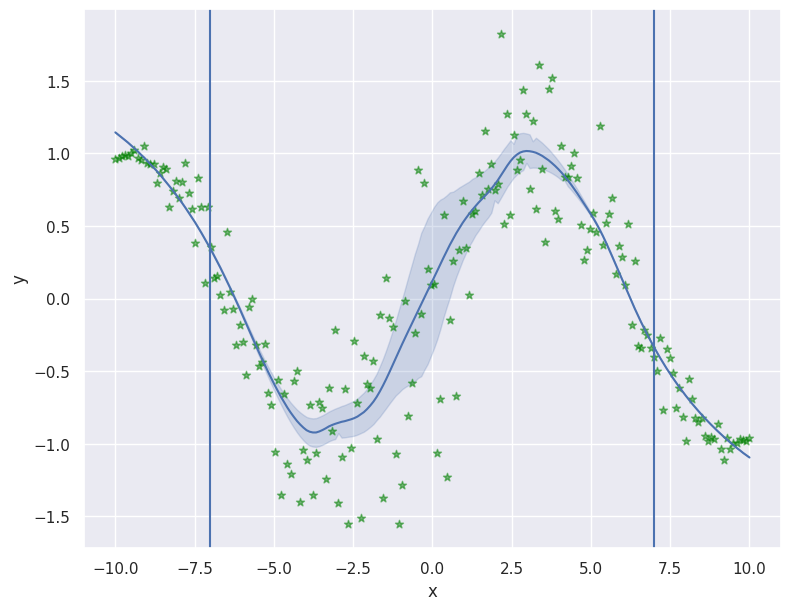

Epoch 10 | batch train loss: 13.090049743652344 | test loss: 30.26000242966872


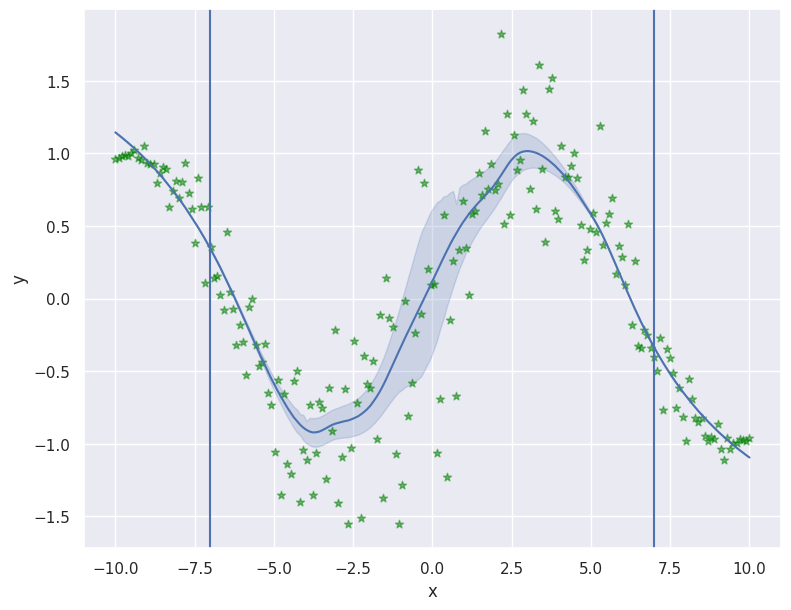

Epoch 20 | batch train loss: 17.73938751220703 | test loss: 28.41936830373911


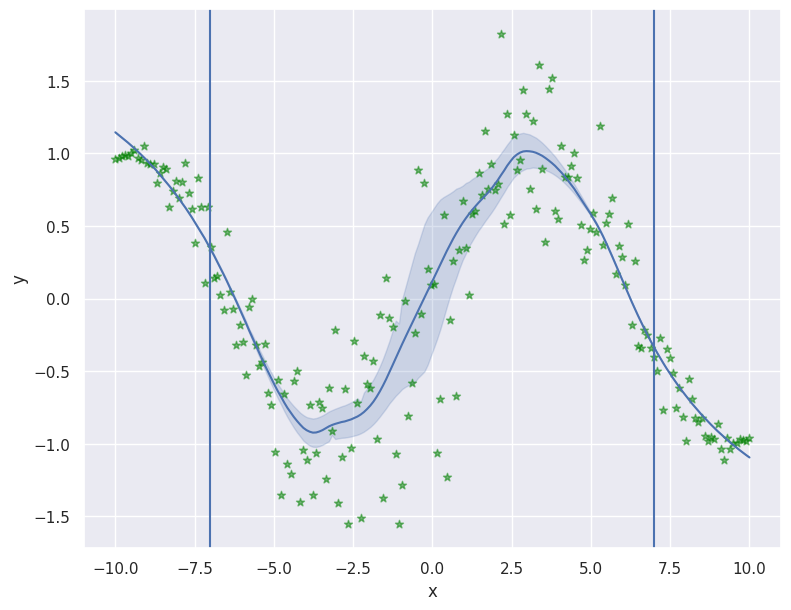

Epoch 30 | batch train loss: 17.209836959838867 | test loss: 29.71005050952618


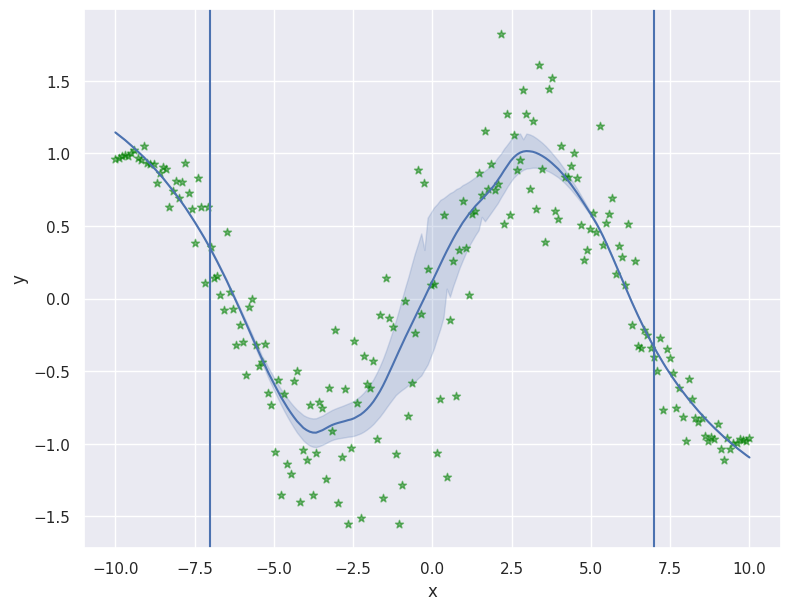

Epoch 40 | batch train loss: 14.018816947937012 | test loss: 30.443474549513596


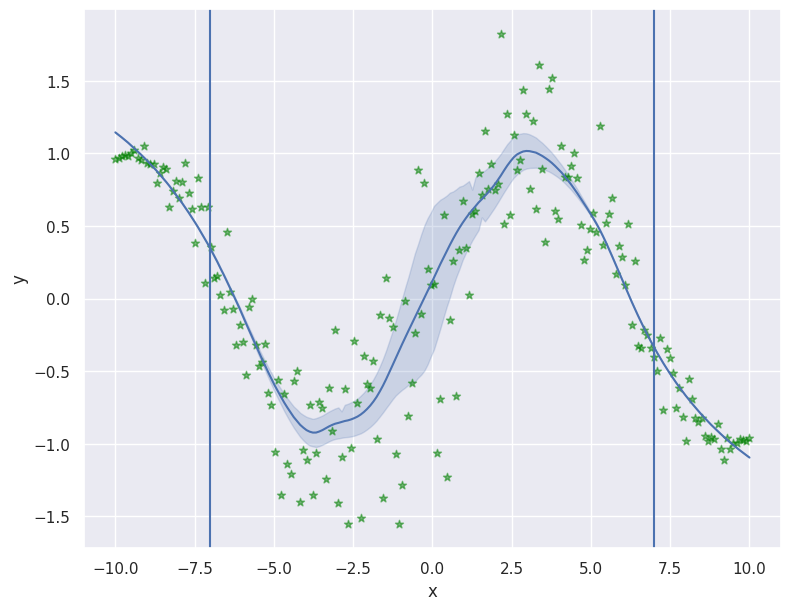

Epoch 50 | batch train loss: 10.399620056152344 | test loss: 29.73779634328989


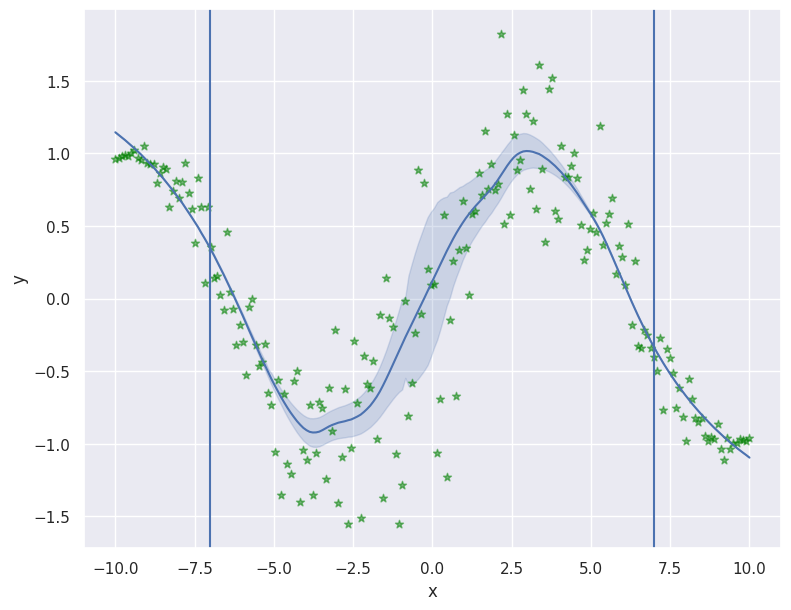

Epoch 60 | batch train loss: 10.870675086975098 | test loss: 28.735973284794735


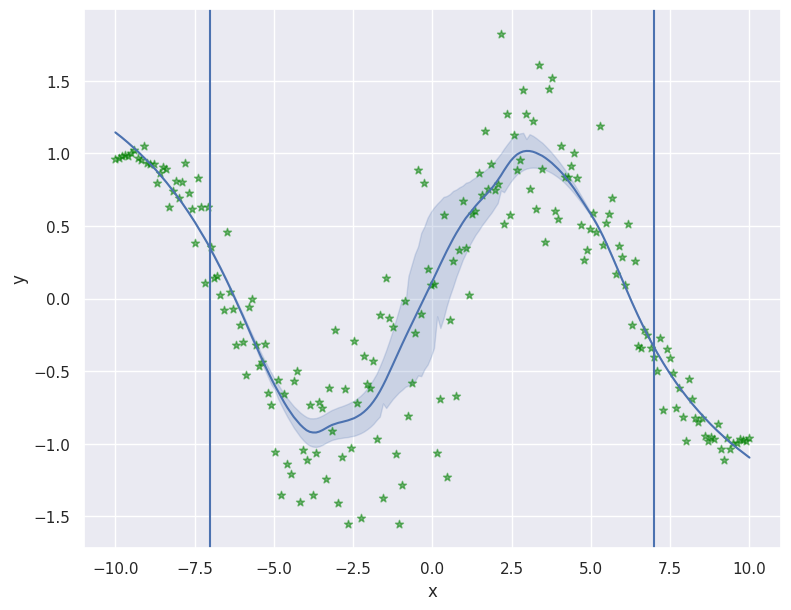

Epoch 70 | batch train loss: 11.710138320922852 | test loss: 28.776338283832256


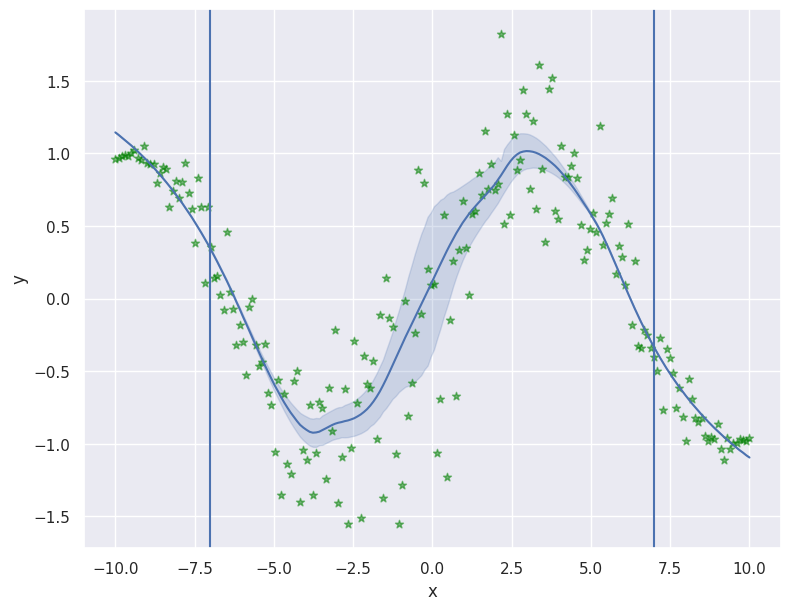

Epoch 80 | batch train loss: 13.80652904510498 | test loss: 29.873891683725212


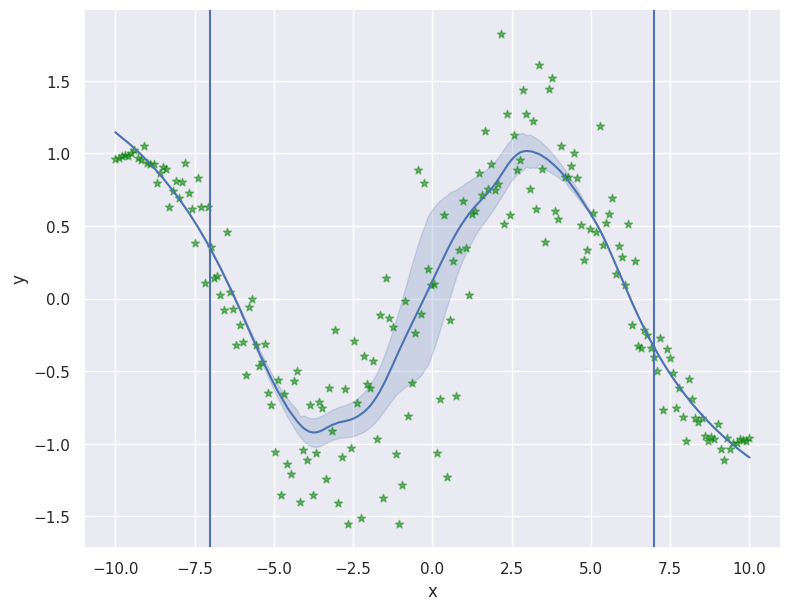

Epoch 90 | batch train loss: 10.611787796020508 | test loss: 30.067152610191933


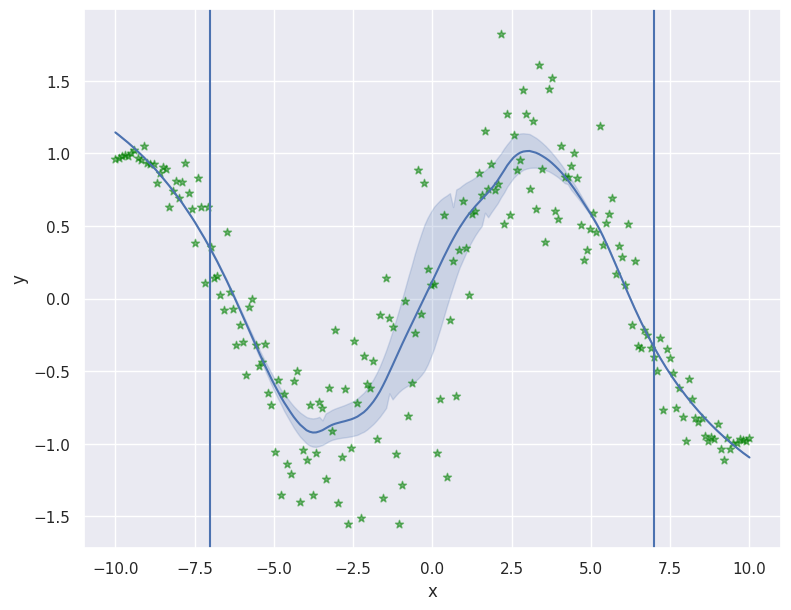

Epoch 100 | batch train loss: 9.346698760986328 | test loss: 29.748408977801983


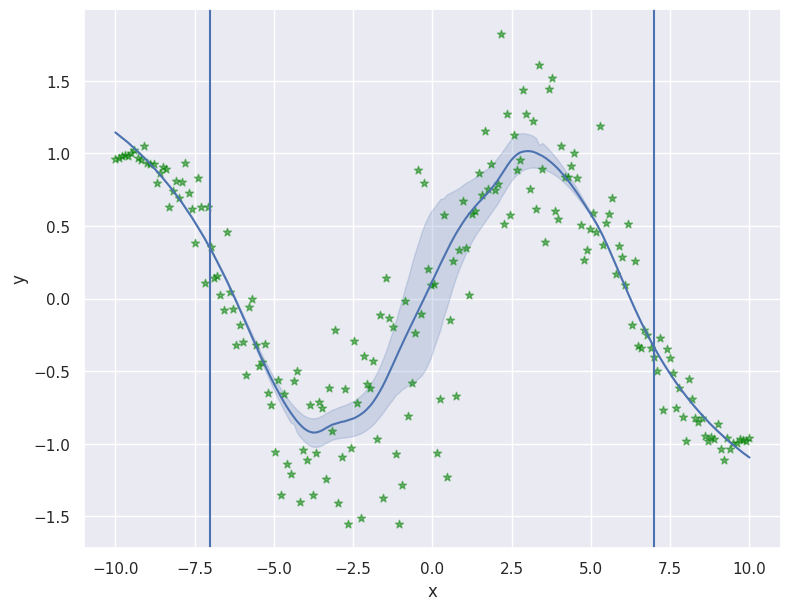

Epoch 110 | batch train loss: 10.497139930725098 | test loss: 28.227687468895546


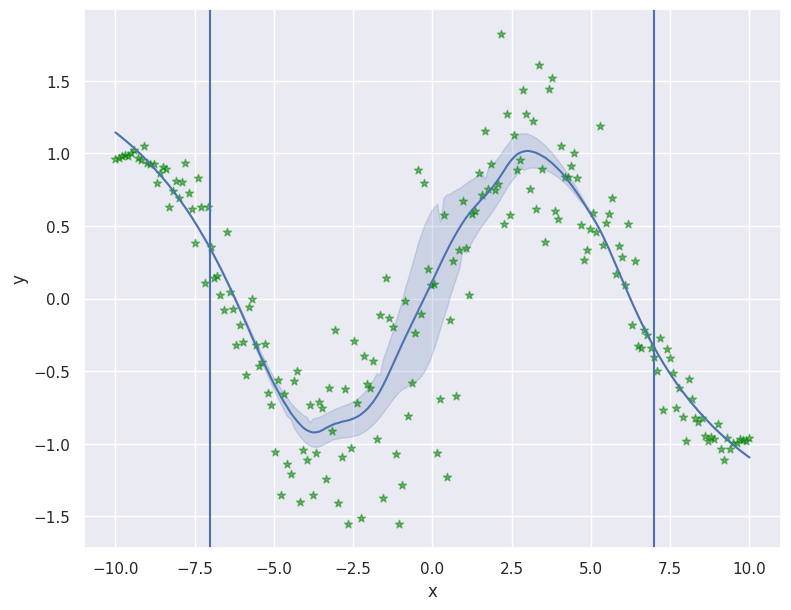

Epoch 120 | batch train loss: 9.998150825500488 | test loss: 28.886859453641453


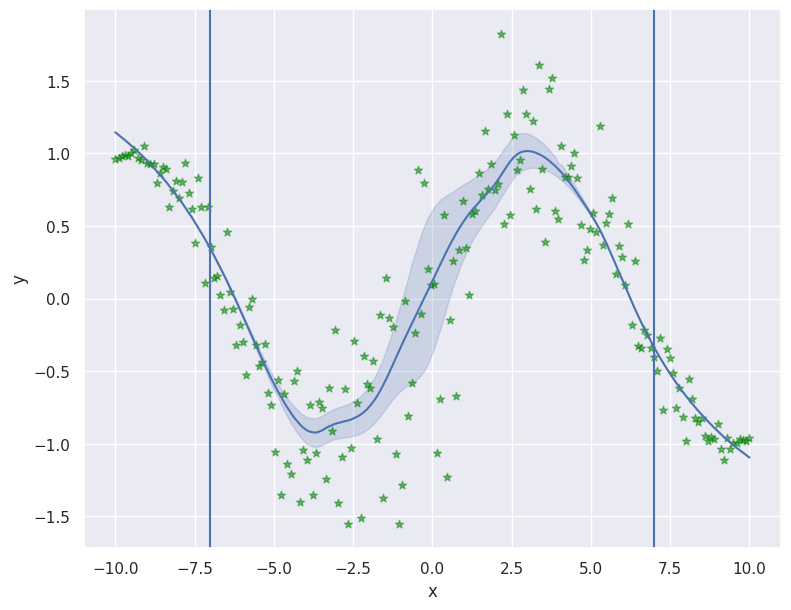

Epoch 130 | batch train loss: 17.960609436035156 | test loss: 28.808247346144455


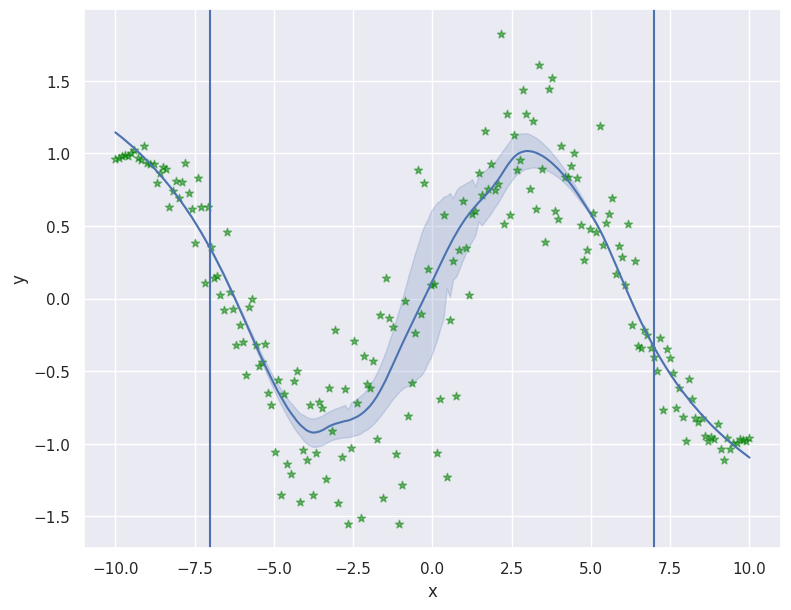

Epoch 140 | batch train loss: 12.45479965209961 | test loss: 30.601412039536697


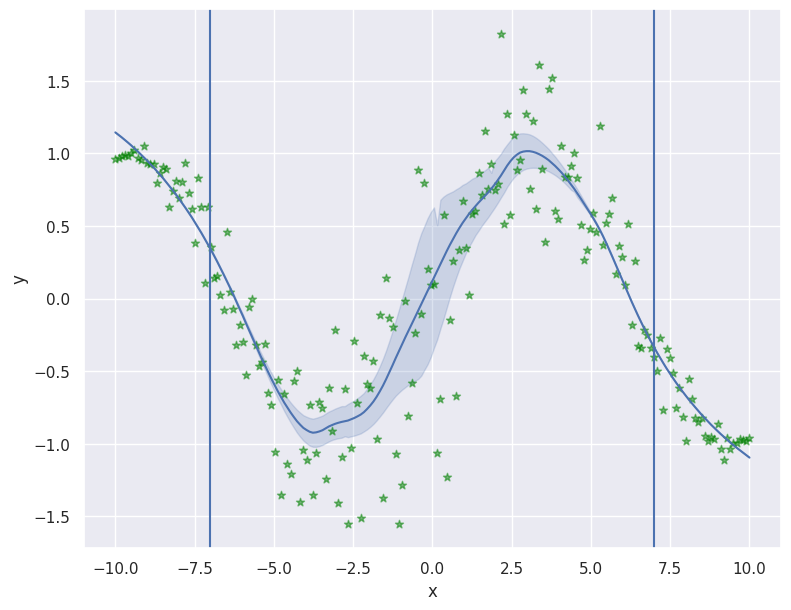

In [58]:
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Loss expects mean, variance and target
criterion = torch.nn.GaussianNLLLoss(eps=1e-02)
optimizer = optim.Adam(net.parameters(), lr=0.001)

net.train()
net.to(device)
for epoch in range(150):
    # Train loop
    for batch in train_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)
        optimizer.zero_grad()
        mu_list_train=[]
        var_list_train=[]
        for _ in range(cycles):
          mu,var=net(x)
          mu_list_train.append(mu)
          var_list_train.append(var)
        mu=average_lists(mu_list_train)
        var=average_lists(var_list_train)
        # Extract the values
        mu = [arr.item() for arr in mu]
        var= [arr.item() for arr in var]
        mu=torch.tensor(mu,requires_grad=True)
        var=torch.tensor(var,requires_grad=True)
        loss = criterion(mu,y,var)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        all_test_losses = []
        # Test loop
        for batch in test_loader:
             x = batch[0].to(device)
             y = batch[1].to(device)
             mu_list_test=[]
             var_list_test=[]
             for _ in range(cycles):
              mu,var=net(x)
              mu_list_test.append(mu)
              var_list_test.append(var)
             mu=average_lists(mu_list_test)
             var=average_lists(var_list_test)
             # Extract the values
             mu = [arr.item() for arr in mu]
             var= [arr.item() for arr in var]
             mu=torch.tensor(mu,requires_grad=True)
             var=torch.tensor(var,requires_grad=True)
             #mu, var = net(x)
             all_test_losses.append(criterion(mu, y, var).item())
        test_loss = sum(all_test_losses)/len(all_test_losses)
        print(f"Epoch {epoch} | batch train loss: {loss} | test loss: {test_loss}")
        make_plot(net)